# Wasserstein GAN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/borchero/pyblaze/blob/master/docs/examples/wgan.ipynb)
[![Download Jupyter Notebbok](https://img.shields.io/badge/Github-Download-brightgreen)](https://github.com/borchero/pyblaze/blob/master/docs/examples/wgan.ipynb)

**_Note: Explanations and theory will be added in the future._**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions as D
import torchvision
import torchvision.transforms as transforms
import pyblaze.nn as xnn
import pyblaze.nn.functional as X
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams['figure.dpi'] = 150

## Data

In [2]:
train_dataset = torchvision.datasets.MNIST(
    root="~/Downloads/", train=True, download=True, transform=transforms.ToTensor()
)

In [3]:
noise_dataset = xnn.NoiseDataset(D.Normal(torch.zeros(2), torch.ones(2)))

In [4]:
critic_iterations = 3

In [5]:
train_loader = train_dataset.loader(batch_size=1024, num_workers=4, drop_last=True, shuffle=True)
noise_loader = noise_dataset.loader(batch_size=1024)
zip_loader = xnn.ZipDataLoader(noise_loader, train_loader, critic_iterations+1, critic_iterations)

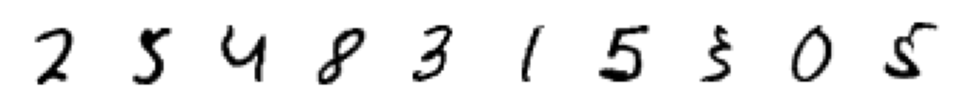

In [6]:
plt.figure()

images = [train_dataset[i] for i in np.random.choice(len(train_dataset), 10)]
for i, (image, _) in enumerate(images):
    plt.subplot(1, 10, i+1)
    plt.imshow(image[0], cmap='binary')
    plt.axis('off')

plt.show()

## Model

In [7]:
class Generator(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 6272),
            nn.ReLU(),
            xnn.View(-1, 128, 7, 7),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.conv(noise)

class Critic(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=5, stride=2, padding=1),
            nn.Flatten(),
            nn.Linear(2304, 1)
        )
        
    def forward(self, x):
        return self.conv(x)


class WGAN(nn.Module):

    def __init__(self):
        super().__init__()
        self.generator = Generator()
        self.critic = Critic()

    def forward(self, noise):
        fake = self.generator(noise)
        return self.critic(fake)

In [8]:
model = WGAN()

print(f'Total parameters:     {sum(p.numel() for p in model.parameters()):6,}')
print(f'Generator parameters: {sum(p.numel() for p in model.generator.parameters()):6,}')
print(f'Critic parameters:    {sum(p.numel() for p in model.critic.parameters()):6,}')

Total parameters:     1,928,450
Generator parameters: 974,401
Critic parameters:    954,049


In [9]:
generator_optimizer = optim.Adam(model.generator.parameters(), lr=3e-4)
critic_optimizer = optim.Adam(model.critic.parameters(), lr=3e-4)
generator_loss = xnn.WassersteinLossGenerator()
gp = xnn.GradientPenalty(model.critic, lipschitz=True)
critic_loss = xnn.WassersteinLossCritic(gp)

In [10]:
engine = xnn.WGANEngine(model, expects_data_target=True)

In [11]:
class PlottingCallback(xnn.TrainingCallback):
    
    def __init__(self, generator, noise_data):
        self.generator = generator
        self.noise_iter = iter(noise_data.loader(batch_size=10))
        self.epoch = None
        
    def before_epoch(self, epoch, iterations):
        self.epoch = epoch
    
    def after_epoch(self, metrics):
        if self.epoch % 10 == 0:
            device = next(self.generator.parameters()).device
            noise = next(self.noise_iter).to(device)
            with torch.no_grad():
                out = self.generator(noise).cpu().numpy()
            self._plot(out)
            
    def _plot(self, out):
        plt.figure()
        for i in range(10):
            plt.subplot(1, 10, i+1)
            plt.imshow(out[i].reshape(28, 28), cmap='binary')
            plt.axis('off')
        plt.show()

Epoch 1/150:
 [Elapsed 0:00:11 | 1.69 it/s] em_distance: 12.85516, loss_critic: -10.55224, loss_generator: 11.88780


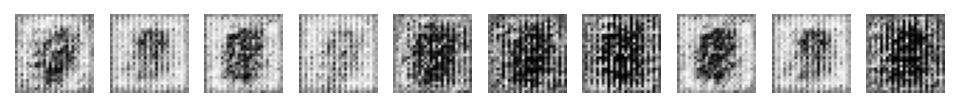

Epoch 2/150:
 [Elapsed 0:00:11 | 1.70 it/s] em_distance: 13.10827, loss_critic: -10.99833, loss_generator: 17.06646
Epoch 3/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 9.35764, loss_critic: -8.12912, loss_generator: 14.46026
Epoch 4/150:
 [Elapsed 0:00:11 | 1.70 it/s] em_distance: 6.96951, loss_critic: -6.18435, loss_generator: 13.29135
Epoch 5/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 6.00915, loss_critic: -5.39060, loss_generator: 11.32450
Epoch 6/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 5.48950, loss_critic: -4.90287, loss_generator: 8.68875
Epoch 7/150:
 [Elapsed 0:00:11 | 1.59 it/s] em_distance: 5.01532, loss_critic: -4.49774, loss_generator: 5.68357
Epoch 8/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 4.72129, loss_critic: -4.26241, loss_generator: 5.54776
Epoch 9/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 4.40615, loss_critic: -3.98436, loss_generator: 5.33843
Epoch 10/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 4.09963, loss_critic: -3.71960, 

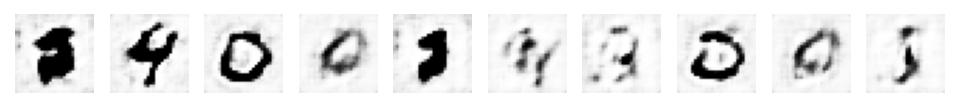

Epoch 12/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 3.73155, loss_critic: -3.40383, loss_generator: 4.55216
Epoch 13/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 3.69323, loss_critic: -3.36895, loss_generator: 5.21412
Epoch 14/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 3.46405, loss_critic: -3.14686, loss_generator: 4.76738
Epoch 15/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 3.47703, loss_critic: -3.17561, loss_generator: 3.49572
Epoch 16/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 3.37328, loss_critic: -3.08496, loss_generator: 5.17119
Epoch 17/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 3.29248, loss_critic: -3.00954, loss_generator: 5.62501
Epoch 18/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 3.17152, loss_critic: -2.90795, loss_generator: 6.16883
Epoch 19/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 3.27178, loss_critic: -2.98983, loss_generator: 5.43840
Epoch 20/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 3.12886, loss_critic: -2.86187

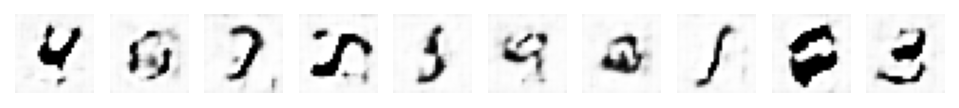

Epoch 22/150:
 [Elapsed 0:00:11 | 1.61 it/s] em_distance: 3.03814, loss_critic: -2.78333, loss_generator: 5.27069
Epoch 23/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.95940, loss_critic: -2.72652, loss_generator: 5.63197
Epoch 24/150:
 [Elapsed 0:00:11 | 1.69 it/s] em_distance: 2.92171, loss_critic: -2.68531, loss_generator: 5.02452
Epoch 25/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 2.95318, loss_critic: -2.72265, loss_generator: 4.14997
Epoch 26/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.93106, loss_critic: -2.69823, loss_generator: 4.66209
Epoch 27/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.84243, loss_critic: -2.61461, loss_generator: 4.37568
Epoch 28/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.72162, loss_critic: -2.50942, loss_generator: 3.63236
Epoch 29/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.69309, loss_critic: -2.48524, loss_generator: 3.35108
Epoch 30/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.61977, loss_critic: -2.42113

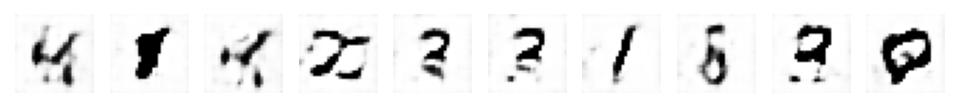

Epoch 32/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.59883, loss_critic: -2.40406, loss_generator: 4.89943
Epoch 33/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.57738, loss_critic: -2.38343, loss_generator: 3.28364
Epoch 34/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.48224, loss_critic: -2.29306, loss_generator: 3.71122
Epoch 35/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.45021, loss_critic: -2.27055, loss_generator: 2.61493
Epoch 36/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.40653, loss_critic: -2.23104, loss_generator: 3.04948
Epoch 37/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.34835, loss_critic: -2.18114, loss_generator: 3.34341
Epoch 38/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.22512, loss_critic: -2.06643, loss_generator: 3.16533
Epoch 39/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.28769, loss_critic: -2.12526, loss_generator: 2.87023
Epoch 40/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 2.35016, loss_critic: -2.17144

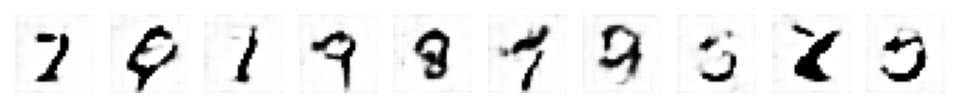

Epoch 42/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.32517, loss_critic: -2.15783, loss_generator: 3.04717
Epoch 43/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.21119, loss_critic: -2.05250, loss_generator: 3.20653
Epoch 44/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.19805, loss_critic: -2.04305, loss_generator: 1.77077
Epoch 45/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.20297, loss_critic: -2.04496, loss_generator: 2.98891
Epoch 46/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.05112, loss_critic: -1.90634, loss_generator: 3.31235
Epoch 47/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.16342, loss_critic: -2.01017, loss_generator: 2.21449
Epoch 48/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.98958, loss_critic: -1.85472, loss_generator: 2.95030
Epoch 49/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.09617, loss_critic: -1.95398, loss_generator: 2.63433
Epoch 50/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 2.09878, loss_critic: -1.95101

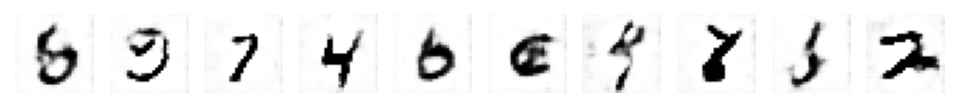

Epoch 52/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 2.10246, loss_critic: -1.95697, loss_generator: 3.31136
Epoch 53/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 2.03862, loss_critic: -1.89756, loss_generator: 3.57213
Epoch 54/150:
 [Elapsed 0:00:11 | 1.61 it/s] em_distance: 2.00240, loss_critic: -1.86592, loss_generator: 3.13696
Epoch 55/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.97102, loss_critic: -1.83984, loss_generator: 2.89116
Epoch 56/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.87301, loss_critic: -1.75050, loss_generator: 3.10123
Epoch 57/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.90962, loss_critic: -1.78343, loss_generator: 3.82211
Epoch 58/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 1.98413, loss_critic: -1.85104, loss_generator: 3.30656
Epoch 59/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 1.81942, loss_critic: -1.70013, loss_generator: 3.20144
Epoch 60/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.85319, loss_critic: -1.73328

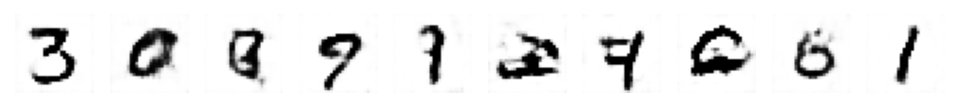

Epoch 62/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 1.85373, loss_critic: -1.73084, loss_generator: 3.44487
Epoch 63/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.84458, loss_critic: -1.72388, loss_generator: 2.39479
Epoch 64/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.82341, loss_critic: -1.70188, loss_generator: 2.54557
Epoch 65/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 1.87736, loss_critic: -1.75238, loss_generator: 3.08654
Epoch 66/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.74074, loss_critic: -1.62804, loss_generator: 2.03615
Epoch 67/150:
 [Elapsed 0:00:11 | 1.61 it/s] em_distance: 1.89547, loss_critic: -1.77116, loss_generator: 2.39258
Epoch 68/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 1.75921, loss_critic: -1.64496, loss_generator: 3.00241
Epoch 69/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.83183, loss_critic: -1.71234, loss_generator: 3.06528
Epoch 70/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.78442, loss_critic: -1.67024

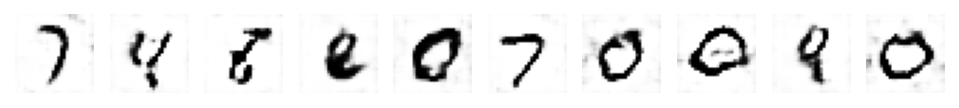

Epoch 72/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.70269, loss_critic: -1.59191, loss_generator: 3.60415
Epoch 73/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.68214, loss_critic: -1.57459, loss_generator: 4.33561
Epoch 74/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.72110, loss_critic: -1.60604, loss_generator: 3.55473
Epoch 75/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.58020, loss_critic: -1.47739, loss_generator: 6.50079
Epoch 76/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.53016, loss_critic: -1.43623, loss_generator: 4.62729
Epoch 77/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.73057, loss_critic: -1.61543, loss_generator: 3.81085
Epoch 78/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.62283, loss_critic: -1.51939, loss_generator: 6.69389
Epoch 79/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.54406, loss_critic: -1.44672, loss_generator: 5.36646
Epoch 80/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.71779, loss_critic: -1.60882

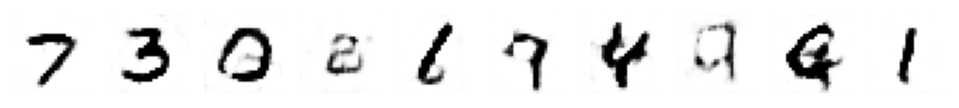

Epoch 82/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.54519, loss_critic: -1.45041, loss_generator: 6.41226
Epoch 83/150:
 [Elapsed 0:00:11 | 1.70 it/s] em_distance: 1.64534, loss_critic: -1.54304, loss_generator: 6.03905
Epoch 84/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.63365, loss_critic: -1.53312, loss_generator: 4.65547
Epoch 85/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.57136, loss_critic: -1.47412, loss_generator: 5.45491
Epoch 86/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.58165, loss_critic: -1.48564, loss_generator: 6.35941
Epoch 87/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.52075, loss_critic: -1.43012, loss_generator: 5.57228
Epoch 88/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.56989, loss_critic: -1.47368, loss_generator: 6.36344
Epoch 89/150:
 [Elapsed 0:00:11 | 1.68 it/s] em_distance: 1.53419, loss_critic: -1.44142, loss_generator: 5.73830
Epoch 90/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.50469, loss_critic: -1.41294

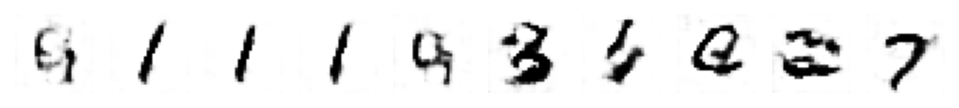

Epoch 92/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.53446, loss_critic: -1.43975, loss_generator: 6.32469
Epoch 93/150:
 [Elapsed 0:00:11 | 1.69 it/s] em_distance: 1.47369, loss_critic: -1.38477, loss_generator: 5.29748
Epoch 94/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.48732, loss_critic: -1.39924, loss_generator: 7.33435
Epoch 95/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.43286, loss_critic: -1.34616, loss_generator: 7.02172
Epoch 96/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.52863, loss_critic: -1.43590, loss_generator: 4.57337
Epoch 97/150:
 [Elapsed 0:00:11 | 1.68 it/s] em_distance: 1.54787, loss_critic: -1.45445, loss_generator: 3.23584
Epoch 98/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.44857, loss_critic: -1.36190, loss_generator: 5.52958
Epoch 99/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.46375, loss_critic: -1.37765, loss_generator: 5.57873
Epoch 100/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.42993, loss_critic: -1.3455

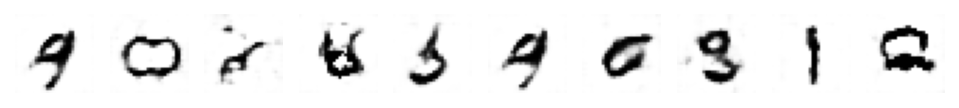

Epoch 102/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.43961, loss_critic: -1.35305, loss_generator: 5.61571
Epoch 103/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.37386, loss_critic: -1.29233, loss_generator: 6.71398
Epoch 104/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.37538, loss_critic: -1.29741, loss_generator: 5.63066
Epoch 105/150:
 [Elapsed 0:00:11 | 1.69 it/s] em_distance: 1.41751, loss_critic: -1.33286, loss_generator: 5.49251
Epoch 106/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.36094, loss_critic: -1.28119, loss_generator: 5.10312
Epoch 107/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.34071, loss_critic: -1.26414, loss_generator: 5.77294
Epoch 108/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.24408, loss_critic: -1.17530, loss_generator: 4.98231
Epoch 109/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.32695, loss_critic: -1.25146, loss_generator: 4.60449
Epoch 110/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.26200, loss_critic:

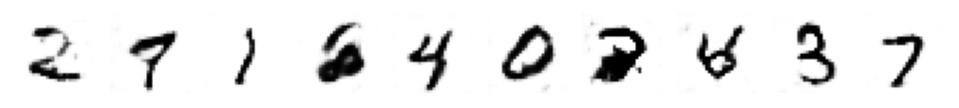

Epoch 112/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.27566, loss_critic: -1.20403, loss_generator: 5.35128
Epoch 113/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.27009, loss_critic: -1.19875, loss_generator: 4.55416
Epoch 114/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.26046, loss_critic: -1.19087, loss_generator: 5.50689
Epoch 115/150:
 [Elapsed 0:00:11 | 1.68 it/s] em_distance: 1.24469, loss_critic: -1.17407, loss_generator: 5.92096
Epoch 116/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.22104, loss_critic: -1.15457, loss_generator: 4.38910
Epoch 117/150:
 [Elapsed 0:00:11 | 1.68 it/s] em_distance: 1.24632, loss_critic: -1.17425, loss_generator: 5.49290
Epoch 118/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.19438, loss_critic: -1.13005, loss_generator: 6.98125
Epoch 119/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.19600, loss_critic: -1.12909, loss_generator: 6.06291
Epoch 120/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.22957, loss_critic:

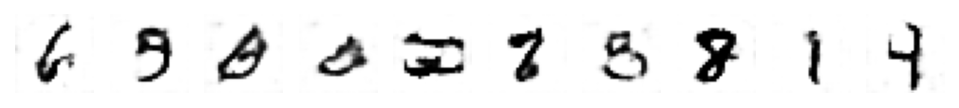

Epoch 122/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.17674, loss_critic: -1.11424, loss_generator: 5.64286
Epoch 123/150:
 [Elapsed 0:00:11 | 1.68 it/s] em_distance: 1.13347, loss_critic: -1.07348, loss_generator: 3.92869
Epoch 124/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.20296, loss_critic: -1.13677, loss_generator: 5.89902
Epoch 125/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.16327, loss_critic: -1.10042, loss_generator: 6.26767
Epoch 126/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.14212, loss_critic: -1.08163, loss_generator: 6.08161
Epoch 127/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.15864, loss_critic: -1.09670, loss_generator: 4.86643
Epoch 128/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.18475, loss_critic: -1.11925, loss_generator: 6.00483
Epoch 129/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.14647, loss_critic: -1.08368, loss_generator: 5.45806
Epoch 130/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.13911, loss_critic:

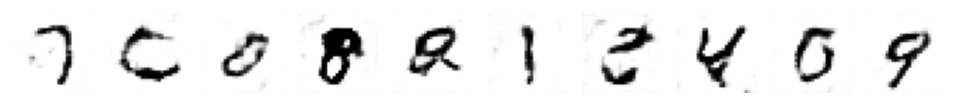

Epoch 132/150:
 [Elapsed 0:00:11 | 1.62 it/s] em_distance: 1.15189, loss_critic: -1.09197, loss_generator: 6.00188
Epoch 133/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.16387, loss_critic: -1.10094, loss_generator: 4.24824
Epoch 134/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.15089, loss_critic: -1.08715, loss_generator: 5.43181
Epoch 135/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.13366, loss_critic: -1.07272, loss_generator: 5.43782
Epoch 136/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.15700, loss_critic: -1.09494, loss_generator: 4.89197
Epoch 137/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.16035, loss_critic: -1.09692, loss_generator: 4.94111
Epoch 138/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.14442, loss_critic: -1.08257, loss_generator: 5.28103
Epoch 139/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.16247, loss_critic: -1.09953, loss_generator: 3.97841
Epoch 140/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.12834, loss_critic:

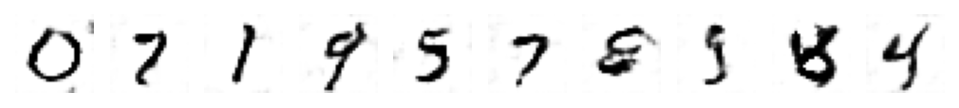

Epoch 142/150:
 [Elapsed 0:00:11 | 1.61 it/s] em_distance: 1.16746, loss_critic: -1.10186, loss_generator: 5.89309
Epoch 143/150:
 [Elapsed 0:00:11 | 1.63 it/s] em_distance: 1.12450, loss_critic: -1.06330, loss_generator: 5.78030
Epoch 144/150:
 [Elapsed 0:00:11 | 1.64 it/s] em_distance: 1.13761, loss_critic: -1.07729, loss_generator: 6.35695
Epoch 145/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.12213, loss_critic: -1.06315, loss_generator: 6.41971
Epoch 146/150:
 [Elapsed 0:00:11 | 1.66 it/s] em_distance: 1.12251, loss_critic: -1.06313, loss_generator: 5.99647
Epoch 147/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.08315, loss_critic: -1.02596, loss_generator: 7.24998
Epoch 148/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.09523, loss_critic: -1.03789, loss_generator: 6.72108
Epoch 149/150:
 [Elapsed 0:00:11 | 1.67 it/s] em_distance: 1.07201, loss_critic: -1.01662, loss_generator: 7.30339
Epoch 150/150:
 [Elapsed 0:00:11 | 1.65 it/s] em_distance: 1.10502, loss_critic:

In [12]:
history = engine.train(
    zip_loader,
    epochs=150,
    generator_optimizer=generator_optimizer,
    critic_optimizer=critic_optimizer,
    generator_loss=generator_loss,
    critic_loss=critic_loss,
    critic_iterations=critic_iterations,
    callbacks=[
        xnn.BatchProgressLogger(),
        PlottingCallback(model.generator, noise_dataset)
    ]
)

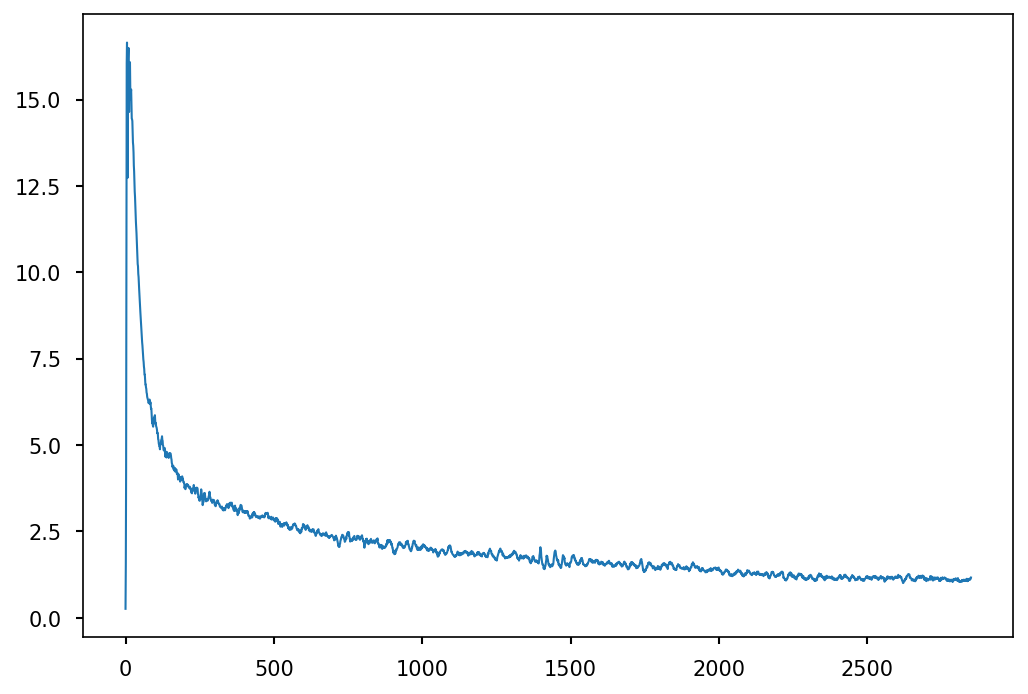

In [13]:
all_losses = history.batch_em_distance
plt.figure()
plt.plot(range(len(all_losses)), all_losses, linewidth=1)
plt.show()

## Evaluation

In [14]:
eval_noise = iter(noise_dataset.loader(batch_size=10))

In [15]:
out = engine.predict(
    eval_noise,
    iterations=1
)

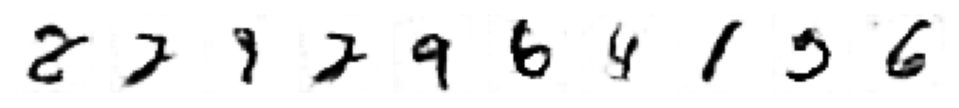

In [16]:
plt.figure(dpi=150)
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(out[i].reshape(28, 28), cmap='binary')
    plt.axis('off')
plt.show()